# Abundance Evolution

LINX is fast enough to be able to generate substantial amounts of data in a short time.  Here we leverage that speed to make a number of different plots exploring the evolution of different element abundances during BBN.

## Preamble

In [1]:
%load_ext autoreload

In [2]:
%autoreload

import sys
sys.path.append('..')

from jax import numpy as jnp

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation 

%matplotlib inline

from plot_params import params
#pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In this notebook, we examine the evolution of abundances as a function of time. 

The class that computes all abundances is `linx.abundances.AbundanceModel`. 

In [4]:
from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.thermo import T_g 
from linx.const import mn, mp, eta0

First, we begin as always by computing the background quantities. We do this for Standard BBN (SBBN). 

In [5]:
bkg_model = BackgroundModel()

# Call the class. 
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.))

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


/home/mkwok/miniconda3/envs/linx/lib/python3.13/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


We also obtain the photon temperature, and define two functions that convert between photon temperature and time, which will be useful for plotting. 

In [6]:
T_g_vec = T_g(rho_g_vec)

def t_to_T(t):
    
    return jnp.interp(t, t_vec, T_g_vec, left=T_g_vec[0]*2, right=T_g_vec[-1]/2)

def T_to_t(T):

    return jnp.interp(T, jnp.flip(T_g_vec), jnp.flip(t_vec), left=t_vec[-1]/2, right=t_vec[0]*2)

## SBBN Abundance Evolution

We are now ready to compute the abundances in SBBN. We use the `key_PRIMAT_2023` rates, setting the baryon abundance $\Omega_b h^2$, the neutron decay lifetime $\tau_n$ and all nuclear rates to their default value. 

We set `save_history=True`, which tells the solver to return the full evolution of all abundances. The output of `AbundanceModel` when this flag is set to `True` is a Diffrax `Solution` class, which evaluate at points given by `t_vec` to obtain an array of abundances. 

In [7]:

abd_model = AbundanceModel(
    NuclearRates(nuclear_net='key_PRIMAT_2023')
)

nuclear_rates_q = jnp.zeros(12)

sol = abd_model(
    rho_g_vec, rho_nu_vec, 
    rho_NP_vec, p_NP_vec,
    t_vec=t_vec, a_vec=a_vec, 
    eta_fac = jnp.asarray(1.), 
    tau_n_fac = jnp.asarray(1.), 
    nuclear_rates_q = nuclear_rates_q,
    save_history=True 
)

abundances = jnp.array([sol.evaluate(t) for t in t_vec])


Compiling abundance model...


First, let's focus just on the abundances of neutrons and protons. We can see here that they are initially in chemical equilibrium, but fall out of chemical equilibrium at around $T_\gamma = $ 0.8 MeV. After that, neutrons decay freely, until the Universe is cool enough that the deuterium bottleneck is overcome, i.e. deuterium nuclei can form without being broken up by photons, which happens at around 0.08 MeV. 

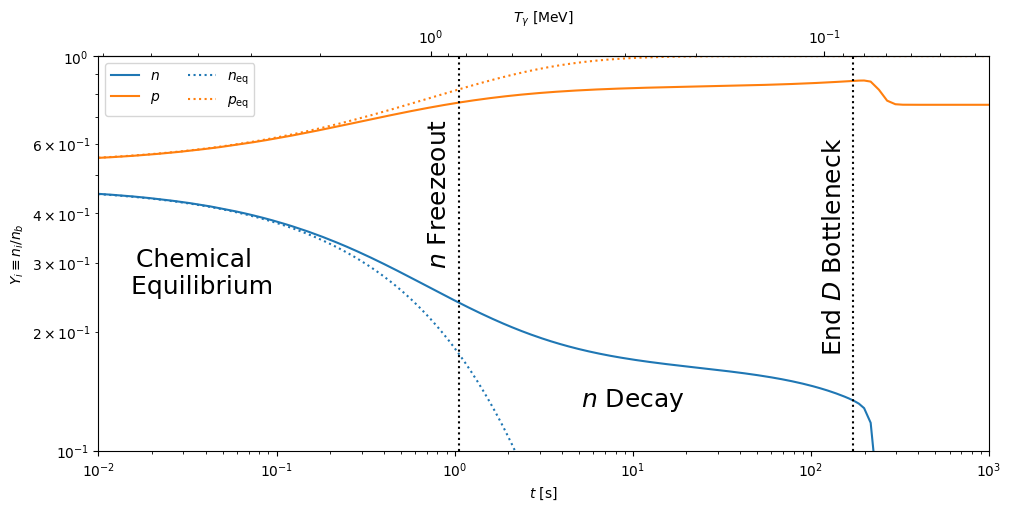

In [8]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

ax.loglog(t_vec, abundances[:, 0], label=r'$n$')
ax.loglog(t_vec, abundances[:, 1], label=r'$p$')

ax.set_prop_cycle(None)

Q = mn - mp

ax.loglog(t_vec, jnp.exp(-Q / T_g_vec) / (1. + jnp.exp(-Q / T_g_vec)), ':', label=r'$n_\mathrm{eq}$')

ax.loglog(t_vec, 1. / (1. + jnp.exp(-Q / T_g_vec)), ':', label=r'$p_\mathrm{eq}$')


ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$Y_i \equiv n_i / n_b$')

ax.tick_params(axis = 'x', which='both', top=False)

ax.axvline(T_to_t(0.84), color='k', ls=':')
ax.axvline(T_to_t(0.085), color='k', ls=':')

ax.text(T_to_t(.95), 0.45, r'$n$ Freezeout', rotation='vertical', va='center', ha='center', fontsize=18)
ax.text(T_to_t(0.095), 0.33, r'End $D$ Bottleneck', rotation='vertical', va='center', ha='center', fontsize=18)
ax.text(T_to_t(4), 0.25, 'Chemical \n Equilibrium', ha='center', fontsize=18)
ax.text(10., 0.13, r'$n$ Decay', ha='center', fontsize=18)


secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')

ax.set_xlim(1e-2, 1000)
ax.set_ylim(0.1, 1.)


plt.legend(ncol=2)

We now plot the rest of the elemental abundances at later times, around the time when the deuterium bottleneck is ending. 

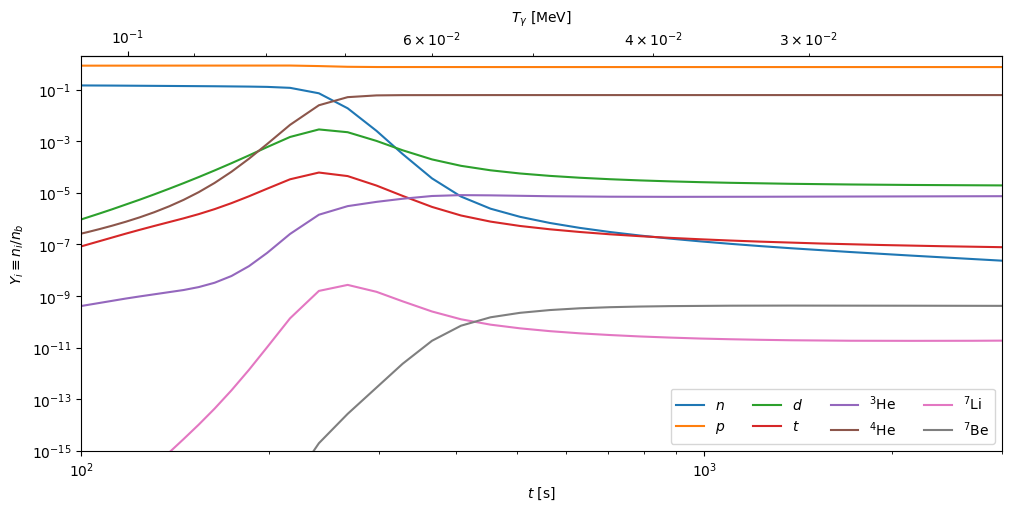

In [9]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

fig_labels = [r'$n$', r'$p$', r'$d$', r'$t$', r'$^3$He', r'$^4$He', r'$^7$Li', r'$^7$Be']

for i in jnp.arange(8):
    ax.loglog(t_vec, abundances[:, i], label=fig_labels[i])

ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$Y_i \equiv n_i / n_b$')

ax.tick_params(axis = 'x', which='both', top=False)

secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')

ax.set_xlim(1e2, 3e3)
ax.set_ylim(1e-15, 2.)

plt.legend(ncol=4, loc='lower right')

plt.show()

In [ ]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='full_PRIMAT_2023')
)

nuclear_rates_q = jnp.zeros(12)

sol = abd_model(
    rho_g_vec, rho_nu_vec, 
    rho_NP_vec, p_NP_vec,
    t_vec=t_vec, a_vec=a_vec, 
    eta_fac = jnp.asarray(1.), 
    tau_n_fac = jnp.asarray(1.), 
    nuclear_rates_q = nuclear_rates_q,
    save_history=True 
)

abundances = jnp.array([sol.evaluate(t) for t in t_vec])

Compiling abundance model...


In [ ]:
fig, ax = plt.subplots(figsize=(5,10))
fig_labels = [r'$n$', r'$p$', r'$d$', r'$t$', r'$^3$He', r'$^4$He', r'$^7$Li', r'$^7$Be',r'$^6$Li', r'$^6$He', r'$^8$Li', r'$^8$Be', r'$^8$B']

for i in range(jnp.shape(abundances)[1]):
    if i < 9:
        ax.loglog(t_vec, abundances[:, i], label=fig_labels[i])
    else:
        ax.loglog(t_vec, abundances[:, i], label=fig_labels[i],ls='--')

ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$Y_i \equiv n_i / n_b$')

ax.tick_params(axis = 'x', which='both', top=False)

secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')

ax.set_xlim(1, 1e4)
ax.set_ylim(1e-37, 2.)

# plt.legend(ncol=4, loc='lower right')
plt.legend(loc=[1,0])

plt.show()

## Nuclear Abundance as a Function of Baryon Abundance

We'll now examine the dependence of the nuclear abundances on $\Omega_b h^2$. To do this, we scan over different values of `eta_fac`, which specifies a factor to multiply the default value of $\Omega_b h^2$ by (this is stored in `const.Omegabh2`). 

In [ ]:
eta_fac_vec = jnp.array([0.1, 0.3, 1., 3., 10.])
eta_fac_fine_vec = jnp.array([0.98, 0.99, 1., 1.01, 1.02])

sol_eta = []
sol_eta_fine = []

for eta_fac in eta_fac_vec: 
    sol = abd_model(
        rho_g_vec, rho_nu_vec, 
        rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec, 
        eta_fac = jnp.asarray(eta_fac), 
        tau_n_fac = jnp.asarray(1.), 
        nuclear_rates_q = nuclear_rates_q,
        save_history=True 
    )
    sol_eta.append(sol) 
for eta_fac_fine in eta_fac_fine_vec: 
    sol = abd_model(
        rho_g_vec, rho_nu_vec, 
        rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec, 
        eta_fac = jnp.asarray(eta_fac_fine), 
        tau_n_fac = jnp.asarray(1.), 
        nuclear_rates_q = nuclear_rates_q,
        save_history=True 
    )
    sol_eta_fine.append(sol) 

The results are to be compared against experimental measurements of D/H and $\text{Y}_\mathrm{P}$. We adopt the results from Aver et al. and Cooke et al.:

In [11]:
DH_mean = 2.527e-5
DH_sig  = 0.03e-5

YP_mean = 0.2449
YP_sig  = 0.004 

And here are the plots! Increased $\Omega_b h^2$ leads to a greater baryon number density, strongly enhancing deuterium burning rates. 

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))


labels_vec = [r'$0.1 \Omega_{b,0} h^2$', r'$0.3 \Omega_{b,0} h^2$', r'$\Omega_{b,0} h^2$', r'$3 \Omega_{b,0} h^2$', r'$10 \Omega_{b,0} h^2$']

for i,sol in enumerate(sol_eta):

    abundances = jnp.array([sol.evaluate(t) for t in t_vec])
    ax.loglog(t_vec, abundances[:,2] / abundances[:, 1], label=labels_vec[i])

ax.tick_params(axis = 'x', which='both', top=False)

secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')


ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'D/H')
ax.set_xlim(10., 1e4)
ax.set_ylim(1e-12, 1e-2)

ax.fill_between(t_vec, DH_mean-DH_sig, DH_mean+DH_sig, color=cols_default[1], alpha=0.3)
ax.fill_between(t_vec, DH_mean-2*DH_sig, DH_mean+2*DH_sig, color=cols_default[1], alpha=0.3)

ax.text(30., 4e-5, r'Cooke+ 2018', ha='center', fontsize=18)

plt.legend(ncols=2)

plt.show()


In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

T_g_vec = T_g(rho_g_vec)

labels_vec = [r'$0.98 \Omega_{b,0} h^2$', r'$0.99 \Omega_{b,0} h^2$', r'$\Omega_{b,0} h^2$', r'$1.01 \Omega_{b,0} h^2$', r'$1.02 \Omega_{b,0} h^2$']

for i,sol in enumerate(sol_eta_fine):

    abundances = jnp.array([sol.evaluate(t) for t in t_vec])
    ax.loglog(t_vec, abundances[:,2] / abundances[:, 1], label=labels_vec[i])

ax.tick_params(axis = 'x', which='both', top=False)

secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')


ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'D/H')

ax.set_xlim(1e3, 3e4)
ax.set_ylim(2e-5, 3e-5)

ax.fill_between(t_vec, DH_mean-DH_sig, DH_mean+DH_sig, color=cols_default[1], alpha=0.3)
ax.fill_between(t_vec, DH_mean-2*DH_sig, DH_mean+2*DH_sig, color=cols_default[1], alpha=0.3)

ax.text(1500., 2.4e-5, r'Cooke+ 2018', ha='center', fontsize=18)



plt.legend(ncols=2)

plt.show()


## Nuclear Abundance Varying with Extra Inert, Relativistic Species

Next, we investigate how the abundances evolve with the addition of an extra inert, relativistic species that simply redshifts as $\rho \propto a^{-4}$. 

We now want to re-solve the background evolution each time, changing $\Delta N_{\text{eff},i}$, the initial value of $\Delta N_\text{eff}$ due to the energy density of the inert species. Please note that this is **not** equal to the final (and measurable) $N_\text{eff}$ due to the same species. 

In [ ]:
Delt_Neff_ary = jnp.linspace(0, 2, num=5)

t_vecs = []
sol_Delt_Neff = [] 

for Delt_Neff in Delt_Neff_ary:

    t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, _ = (
        bkg_model(Delt_Neff)
    )

    sol = abd_model(
        rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec,
        eta_fac = jnp.asarray(1.),
        tau_n_fac = jnp.asarray(1.),
        nuclear_rates_q = nuclear_rates_q, 
        save_history=True
    )

    t_vecs.append(t_vec)
    sol_Delt_Neff.append(sol)



First, let's examine the impact on the neutron abundance and Y$_\mathrm{P}$. Additional degrees of freedom causes neutron freezeout to occur earlier, and gives neutrons less time to decay away. 

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

labels_vec = [r'$\Delta N_{\mathrm{eff},i} = 0$', r'$\Delta N_{\mathrm{eff},i} = 0.5$', r'$\Delta N_{\mathrm{eff},i} = 1$', r'$\Delta N_{\mathrm{eff},i} = 1.5$', r'$\Delta N_{\mathrm{eff},i} = 2$']

for i,sol in enumerate(sol_Delt_Neff):

    abundances = jnp.array([sol.evaluate(t) for t in t_vecs[i]])
    ax.loglog(t_vecs[i], abundances[:,0], label=labels_vec[i])

    ax.set_xlabel(r'$t$ [s]')
    ax.set_ylabel(r'$Y_n$')

ax.tick_params(axis = 'x', which='both', top=False)

ax.set_xlim(1, 1e2)
ax.set_ylim(0.14, 0.2)

plt.legend(ncols=2)

plt.show()

fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

labels_vec = [r'$\Delta N_{\mathrm{eff},i} = 0$', r'$\Delta N_{\mathrm{eff},i} = 0.5$', r'$\Delta N_{\mathrm{eff},i} = 1$', r'$\Delta N_{\mathrm{eff},i} = 1.5$', r'$\Delta N_{\mathrm{eff},i} = 2$']

for i,sol in enumerate(sol_Delt_Neff):

    abundances = jnp.array([sol.evaluate(t) for t in t_vecs[i]])
    ax.loglog(t_vecs[i], abundances[:,5] * 4 , label=labels_vec[i])

    ax.set_xlabel(r'$t$ [s]')
    ax.set_ylabel(r'$Y_\mathrm{P}$')

ax.tick_params(axis = 'x', which='both', top=False)

ax.fill_between(t_vec, YP_mean-YP_sig, YP_mean+YP_sig, color=cols_default[1], alpha=0.3)
ax.fill_between(t_vec, YP_mean-2*YP_sig, YP_mean+2*YP_sig, color=cols_default[1], alpha=0.3)

ax.set_xlim(1e2, 1e4)
ax.set_ylim(0.23, 0.27)
ax.set_yscale('linear')

ax.text(180., 0.254, r'Aver+ 2015', ha='center', fontsize=18)


plt.legend(ncols=2)

plt.show()


There is also an impact on D/H and deuterium freezeout: 

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

labels_vec = [r'$\Delta N_{\mathrm{eff},i} = 0$', r'$\Delta N_{\mathrm{eff},i} = 0.5$', r'$\Delta N_{\mathrm{eff},i} = 1$', r'$\Delta N_{\mathrm{eff},i} = 1.5$', r'$\Delta N_{\mathrm{eff},i} = 2$']

for i,sol in enumerate(sol_Delt_Neff):

    abundances = jnp.array([sol.evaluate(t) for t in t_vecs[i]])
    ax.loglog(t_vecs[i], abundances[:,2] / abundances[:,1], label=labels_vec[i])

    ax.set_xlabel(r'$t$ [s]')
    ax.set_ylabel(r'D/H')

ax.tick_params(axis = 'x', which='both', top=False)

ax.fill_between(t_vec, DH_mean-DH_sig, DH_mean+DH_sig, color=cols_default[1], alpha=0.3)
ax.fill_between(t_vec, DH_mean-2*DH_sig, DH_mean+2*DH_sig, color=cols_default[1], alpha=0.3)

ax.set_xlim(1e3, 1e4)
ax.set_ylim(2e-5, 3e-5)
ax.text(1500., 2.4e-5, r'Cooke+ 2018', ha='center', fontsize=18)

plt.legend(ncols=2)

plt.show()

## Making Movies

Finally, we'll make use of LINX's speed to do something fun: making animations of the change in abundances as a function of $\Omega_b h^2$. Check out `abundances.gif` once the code completes!

In [17]:
eta_fac_vec = jnp.logspace(-1, 1, num=50)

sol_eta = []

t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(0.) 

for eta_fac in eta_fac_vec: 
    sol = abd_model(
        rho_g_vec, rho_nu_vec, 
        rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec, 
        eta_fac = jnp.asarray(eta_fac), 
        tau_n_fac = jnp.asarray(1.), 
        nuclear_rates_q = nuclear_rates_q,
        save_history=True 
    )
    sol_eta.append(sol) 

    

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

abundances = jnp.array([sol_eta[0].evaluate(t) for t in t_vec])

n_plot, = ax.loglog(t_vec, abundances[:, 0], label=r'$n$')
p_plot, = ax.loglog(t_vec, abundances[:, 1], label=r'$p$')
d_plot, = ax.loglog(t_vec, abundances[:, 2], label=r'$d$')
t_plot, = ax.loglog(t_vec, abundances[:, 3], label=r'$t$')
He3_plot, = ax.loglog(t_vec, abundances[:, 4], label=r'$^3$He')
He4_plot, = ax.loglog(t_vec, abundances[:, 5], label=r'$^4$He')
Li7_plot, = ax.loglog(t_vec, abundances[:, 6], label=r'$^7$Li')
Be7_plot, = ax.loglog(t_vec, abundances[:, 7], label=r'$^7$Be')


ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$Y_i \equiv n_i / n_b$')    
ax.tick_params(axis = 'x', which='both', top=False)

def animate(i):

    abundances = jnp.array([sol_eta[i].evaluate(t) for t in t_vec])
    
    n_plot.set_xdata(t_vec)
    n_plot.set_ydata(abundances[:, 0]) 
    p_plot.set_xdata(t_vec)
    p_plot.set_ydata(abundances[:, 1]) 
    d_plot.set_xdata(t_vec)
    d_plot.set_ydata(abundances[:, 2]) 
    t_plot.set_xdata(t_vec)
    t_plot.set_ydata(abundances[:, 3]) 
    He3_plot.set_xdata(t_vec)
    He3_plot.set_ydata(abundances[:, 4]) 
    He4_plot.set_xdata(t_vec)
    He4_plot.set_ydata(abundances[:, 5]) 
    Li7_plot.set_xdata(t_vec)
    Li7_plot.set_ydata(abundances[:, 6]) 
    Be7_plot.set_xdata(t_vec)
    Be7_plot.set_ydata(abundances[:, 7]) 


    ax.set_title(r'Baryon-to-Photon Ratio $\eta = $ {:.2E}'.format(eta_fac_vec[i]*eta0))

    return None


secax = ax.secondary_xaxis('top', functions=(t_to_T, T_to_t))
secax.set_xlabel(r'$T_\gamma$ [MeV]')

ax.set_xlim(1e2, 3e3)
ax.set_ylim(1e-15, 2.)


plt.legend(ncol=4, loc='lower right')

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=50)
ani.save('abundances.gif')

plt.show()
